# ***Intelligent Resume Screening System***

In [119]:
#Install Required Libraries
!pip install -q nltk scikit-learn matplotlib seaborn

In [120]:
#Import Libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import pickle
from google.colab import files

In [121]:
#Download NLTK (Natural Language Toolkit) Resources
nltk.download('punkt_tab')  # for word_tokenize
nltk.download('stopwords')  # for stopwords
nltk.download('wordnet')    # for WordNetLemmatizer
nltk.download('omw-1.4')    # WordNet data

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [122]:
#Upload Resume Dataset
print("Upload your resumes CSV file (columns: Resume_ID, Name, Skills, Experience (Years), Education, Certifications, Job Role, Salary Expectation ($), Projects Count)")
uploaded_resumes = files.upload()
resume_filename = list(uploaded_resumes.keys())[0]
df_resumes = pd.read_csv(resume_filename)
print("Resume Dataset Loaded:")
df_resumes.head()

Upload your resumes CSV file (columns: Resume_ID, Name, Skills, Experience (Years), Education, Certifications, Job Role, Salary Expectation ($), Projects Count)


Saving AI Resume Screening Dataset.csv to AI Resume Screening Dataset.csv
Resume Dataset Loaded:


,Resume_ID,Name,Skills,Experience (Years),Education,Certifications,Job Role,Recruiter Decision,Salary Expectation ($),Projects Count,AI Score (0-100)
0,1,Ashley Ali,"TensorFlow, NLP, Pytorch",10,B.Sc,NaN,AI Researcher,Hire,104895,8,100
1,2,Wesley Roman,"Deep Learning, Machine Learning, Python, SQL",10,MBA,Google ML,Data Scientist,Hire,113002,1,100
2,3,Corey Sanchez,"Ethical Hacking, Cybersecurity, Linux",1,MBA,Deep Learning Specialization,Cybersecurity Analyst,Hire,71766,7,70
3,4,Elizabeth Carney,"Python, Pytorch, TensorFlow",7,B.Tech,AWS Certified,AI Researcher,Hire,46848,0,95
4,5,Julie Hill,"SQL, React, Java",4,PhD,NaN,Software Engineer,Hire,87441,9,100


In [123]:
#Upload Job Descriptions CSV
print("Upload your Job Descriptions CSV file (columns: JobID, Title, ExperienceLevel, YearsOfExperience, Skills, Responsibilities, Keywords)")
uploaded_jobs = files.upload()
job_filename = list(uploaded_jobs.keys())[0]
df_jobs = pd.read_csv(job_filename)
print("Job Descriptions Dataset Loaded:")
df_jobs.head()

Upload your Job Descriptions CSV file (columns: JobID, Title, ExperienceLevel, YearsOfExperience, Skills, Responsibilities, Keywords)


Saving Job Descriptions.csv to Job Descriptions.csv
Job Descriptions Dataset Loaded:


,JobID,Title,ExperienceLevel,YearsOfExperience,Skills,Responsibilities,Keywords
0,NET-F-001,.NET Developer,Fresher,0-1,C#; VB.NET basics; .NET Framework; .NET Core f...,Assist in coding and debugging applications; L...,.NET; C#; ASP.NET MVC; Entity Framework; SQL S...
1,NET-F-002,.NET Developer,Fresher,0-1,C#; .NET Framework basics; ASP.NET; Razor; HTM...,Write simple C# programs under guidance; Suppo...,.NET; C#; ASP.NET MVC; Entity Framework; SQL S...
2,NET-F-003,.NET Developer,Fresher,0-1,C#; VB.NET basics; .NET Core; ASP.NET MVC; HTM...,Contribute to development of small modules; As...,.NET; C#; ASP.NET MVC; SQL Server; Entity Fram...
3,NET-F-004,.NET Developer,Fresher,0-1,C#; .NET Framework; ASP.NET basics; SQL Server...,Support in software design documentation; Assi...,.NET; C#; SQL Server; Entity Framework; ASP.NET
4,NET-F-005,.NET Developer,Fresher,0-1,C#; ASP.NET; MVC; Entity Framework basics; SQL...,Learn to design and build ASP.NET applications...,.NET; C#; ASP.NET MVC; Entity Framework; SQL S...


In [124]:
#Text Preprocessing Function
stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\+?\d[\d\s\-]{8,}\d', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = nltk.word_tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(cleaned_tokens)

In [125]:
# Combine Relevant Resume Columns for NLP
df_resumes['Resume_Text'] = df_resumes['Skills'].fillna('') + ' ' + \
                            df_resumes['Education'].fillna('') + ' ' + \
                            df_resumes['Job Role'].fillna('') + ' ' + \
                            df_resumes['Certifications'].fillna('')

# Check
df_resumes[['Resume_Text']].head()

,Resume_Text
0,"TensorFlow, NLP, Pytorch B.Sc AI Researcher"
1,"Deep Learning, Machine Learning, Python, SQL M..."
2,"Ethical Hacking, Cybersecurity, Linux MBA Cybe..."
3,"Python, Pytorch, TensorFlow B.Tech AI Research..."
4,"SQL, React, Java PhD Software Engineer"


In [126]:
#Combine Job Columns into Single Text
df_jobs['combined_job_text'] = df_jobs['Title'].fillna('') + ' ' + \
                               df_jobs['ExperienceLevel'].fillna('') + ' ' + \
                               df_jobs['Skills'].fillna('') + ' ' + \
                               df_jobs['Responsibilities'].fillna('') + ' ' + \
                               df_jobs['Keywords'].fillna('')

# Check
df_jobs[['combined_job_text']].head()

,combined_job_text
0,.NET Developer Fresher C#; VB.NET basics; .NET...
1,.NET Developer Fresher C#; .NET Framework basi...
2,.NET Developer Fresher C#; VB.NET basics; .NET...
3,.NET Developer Fresher C#; .NET Framework; ASP...
4,.NET Developer Fresher C#; ASP.NET; MVC; Entit...


In [127]:
# Preprocess Resumes
df_resumes['cleaned_resume'] = df_resumes['Resume_Text'].apply(clean_text)

# Clean combined job text
df_jobs['cleaned_job'] = df_jobs['combined_job_text'].apply(clean_text)

print("Preprocessing Completed for Resumes and Job Descriptions.")

Preprocessing Completed for Resumes and Job Descriptions.


In [128]:
#TF-IDF(Term Frequency – Inverse Document Frequency) Feature Extraction (Resumes)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
X_resumes = tfidf.fit_transform(df_resumes['cleaned_resume'])
y = df_resumes['Job Role']

# Save TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

print("TF-IDF Feature Extraction Done. Shape:", X_resumes.shape)


TF-IDF Feature Extraction Done. Shape: (1000, 170)


In [129]:
#Train Logistic Regression Model
X_train, X_test, y_train, y_test = train_test_split(
    X_resumes, y, test_size=0.2, random_state=42, stratify=y
)

lr_model = LogisticRegression(max_iter=1000, n_jobs=-1)
lr_model.fit(X_train, y_train)

# Save the model
with open("resume_classifier.pkl", "wb") as f:
    pickle.dump(lr_model, f)

Accuracy: 1.0

Classification Report:
                        precision    recall  f1-score   support

        AI Researcher       1.00      1.00      1.00        51
Cybersecurity Analyst       1.00      1.00      1.00        51
       Data Scientist       1.00      1.00      1.00        51
    Software Engineer       1.00      1.00      1.00        47

             accuracy                           1.00       200
            macro avg       1.00      1.00      1.00       200
         weighted avg       1.00      1.00      1.00       200



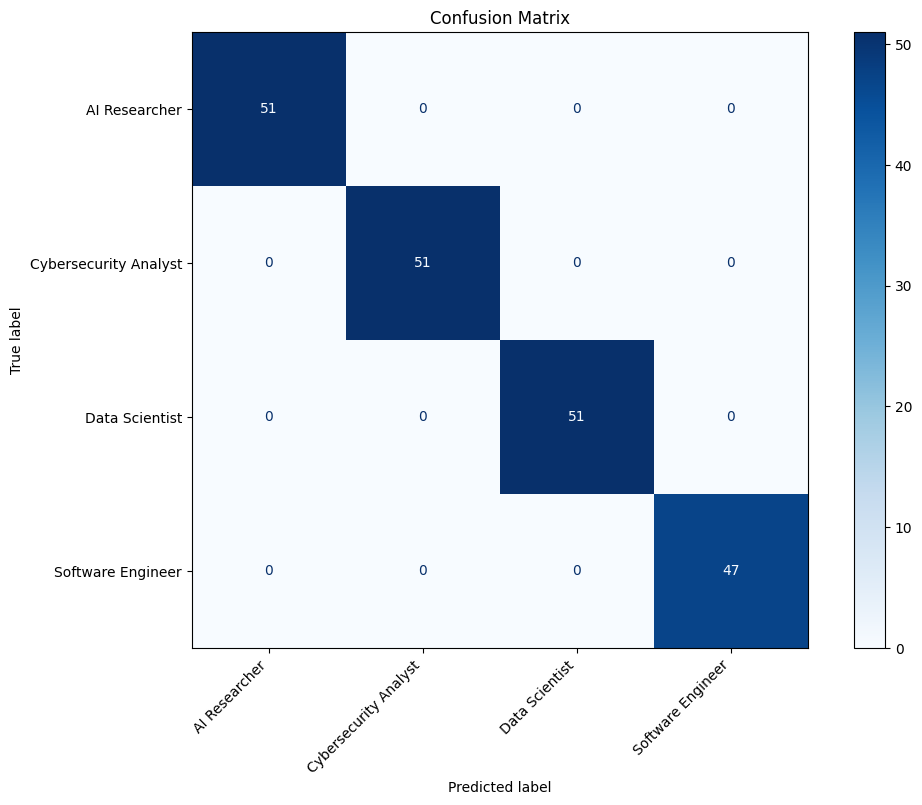

In [130]:
# Evaluate Model with Clear Confusion Matrix
y_pred = lr_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix with readable labels
cm = confusion_matrix(y_test, y_pred, labels=lr_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
fig, ax = plt.subplots(figsize=(12,8))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Confusion Matrix")
plt.show()

In [131]:
# 10.Resume-Job Matching for All Jobs
def match_resumes_for_jobs(top_n=5, threshold=0.5):
    all_results = []

    for i, job_row in df_jobs.iterrows():
        job_vector = tfidf.transform([job_row['cleaned_job']])
        similarity_scores = cosine_similarity(X_resumes, job_vector).flatten()

        df_temp = df_resumes.copy()
        df_temp['similarity_score'] = similarity_scores
        df_temp['shortlist'] = df_temp['similarity_score'] >= threshold

        df_sorted = df_temp.sort_values(by='similarity_score', ascending=False).head(top_n)

        all_results.append({
            'JobID': job_row['JobID'],
            'Job_Title': job_row['Title'],
            'Top_Candidates': df_sorted[['Resume_ID', 'Name', 'Resume_Text', 'similarity_score', 'shortlist']]
        })

    return all_results

# Run matching
results = match_resumes_for_jobs(top_n=5, threshold=0.5)
print("Resume-Job Matching Completed.")

Resume-Job Matching Completed.


In [132]:
# 11: Display Top Candidates for Each Job
for r in results:
    print(f"\n=== JobID: {r['JobID']} | Title: {r['Job_Title']} ===")
    print(r['Top_Candidates'])

Streaming output truncated to the last 5000 lines.

=== JobID: JD-JAVA-010 | Title: Java Developer ===
     Resume_ID              Name  ... similarity_score  shortlist
340        341   Austin Saunders  ...         0.314433      False
652        653  Mr. Kevin Guzman  ...         0.283509      False
928        929   Melinda Lambert  ...         0.283509      False
894        895    Timothy Thomas  ...         0.283509      False
958        959     Jesus Johnson  ...         0.282373      False

[5 rows x 5 columns]

=== JobID: JD-JAVA-011 | Title: Java Developer ===
     Resume_ID              Name  ... similarity_score  shortlist
894        895    Timothy Thomas  ...         0.339705      False
928        929   Melinda Lambert  ...         0.339705      False
652        653  Mr. Kevin Guzman  ...         0.339705      False
777        778      Megan Juarez  ...         0.338344      False
958        959     Jesus Johnson  ...         0.338344      False

[5 rows x 5 columns]

=== JobI

In [133]:
# 13: Save Only Shortlisted Resumes to CSV
export_results = []
for r in results:
    df_top = r['Top_Candidates']
    # Filter only shortlisted resumes
    df_top_shortlist = df_top[df_top['shortlist'] == True]

    for idx, row in df_top_shortlist.iterrows():
        export_results.append({
            'JobID': r['JobID'],
            'Job_Title': r['Job_Title'],
            'Resume_ID': row['Resume_ID'],
            'Name': row['Name'],
            'Similarity_Score': row['similarity_score']
        })

# Create DataFrame
results_df = pd.DataFrame(export_results)

# Save to CSV
results_df.to_csv("resume_matching_shortlisted.csv", index=False)
files.download("resume_matching_shortlisted.csv")
print("Only shortlisted resumes saved and downloaded as resume_matching_shortlisted.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Only shortlisted resumes saved and downloaded as resume_matching_shortlisted.csv
